In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import yfinance as yf


In [2]:
# Download historical stock price data from Yahoo Finance
stock_data = yf.download('AMZN', start='2010-01-01', end='2023-01-01')

# Display the first few rows of the dataset
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,6.8125,6.8305,6.6570,6.6950,6.6950,151998000
2010-01-05,6.6715,6.7740,6.5905,6.7345,6.7345,177038000
2010-01-06,6.7300,6.7365,6.5825,6.6125,6.6125,143576000
2010-01-07,6.6005,6.6160,6.4400,6.5000,6.5000,220604000
2010-01-08,6.5280,6.6840,6.4515,6.6760,6.6760,196610000


In [3]:
stock_data.shape

(3272, 6)

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2010-01-04 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3272 non-null   float64
 1   High       3272 non-null   float64
 2   Low        3272 non-null   float64
 3   Close      3272 non-null   float64
 4   Adj Close  3272 non-null   float64
 5   Volume     3272 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 178.9 KB


In [5]:
stock_data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,3272.00,3272.00,3272.00,3272.00,3272.00,3.272000e+03
mean,58.94,59.62,58.19,58.91,58.91,8.833206e+07
std,54.13,54.78,53.40,54.08,54.08,5.308631e+07
min,5.30,5.56,5.29,5.43,5.43,1.762600e+07
25%,13.35,13.47,13.20,13.33,13.33,5.611750e+07
50%,36.33,36.54,36.05,36.39,36.39,7.457900e+07
75%,93.01,94.17,92.02,93.13,93.13,1.037110e+08
max,187.20,188.65,184.84,186.57,186.57,8.484220e+08


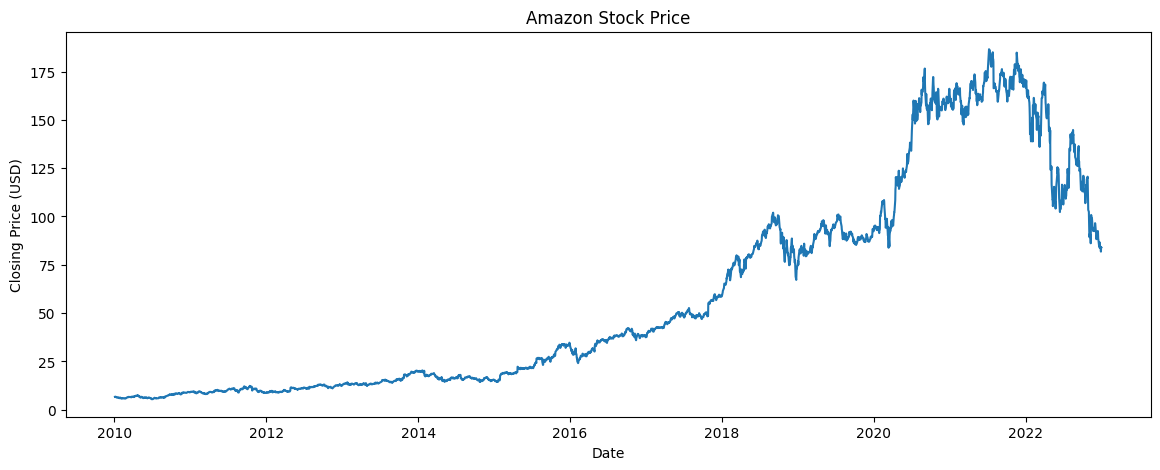

In [6]:
# Plot the closing prices
plt.figure(figsize=(14, 5))
plt.plot(stock_data['Close'])
plt.title('Amazon Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()


In [7]:
# Preprocess the data
data = stock_data[['Close']].values

# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with 60 timestamps and 1 output
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data for LSTM model [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
# Build the LSTM model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))
model.add(Dense(units=1))


In [9]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
101/101 [==============================] - 50s 152ms/step - loss: 0.0043
Epoch 2/20
101/101 [==============================] - 16s 154ms/step - loss: 5.6234e-04
Epoch 3/20
101/101 [==============================] - 16s 154ms/step - loss: 5.0883e-04
Epoch 4/20
101/101 [==============================] - 16s 155ms/step - loss: 4.9450e-04
Epoch 5/20
101/101 [==============================] - 16s 159ms/step - loss: 4.4197e-04
Epoch 6/20
101/101 [==============================] - 16s 157ms/step - loss: 4.3696e-04
Epoch 7/20
101/101 [==============================] - 15s 147ms/step - loss: 3.9948e-04
Epoch 8/20
101/101 [==============================] - 15s 146ms/step - loss: 4.4594e-04
Epoch 9/20
101/101 [==============================] - 15s 148ms/step - loss: 3.2440e-04
Epoch 10/20
101/101 [==============================] - 16s 155ms/step - loss: 3.0338e-04
Epoch 11/20
101/101 [==============================] - 15s 144ms/step - loss: 3.1700e-04
Epoch 12/20
101/101 [=============

In [11]:
# Load test data for prediction
test_data = yf.download('AMZN', start='2023-01-01', end='2024-01-01')
actual_prices = test_data['Close'].values

[*********************100%%**********************]  1 of 1 completed


In [12]:
# Prepare the input data for predictions
total_data = pd.concat((stock_data['Close'], test_data['Close']), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
# Make predictions on the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 8s 52ms/step


In [14]:
# Calculate the Mean Squared Error
mse = np.mean((predictions - actual_prices) ** 2)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 704.89


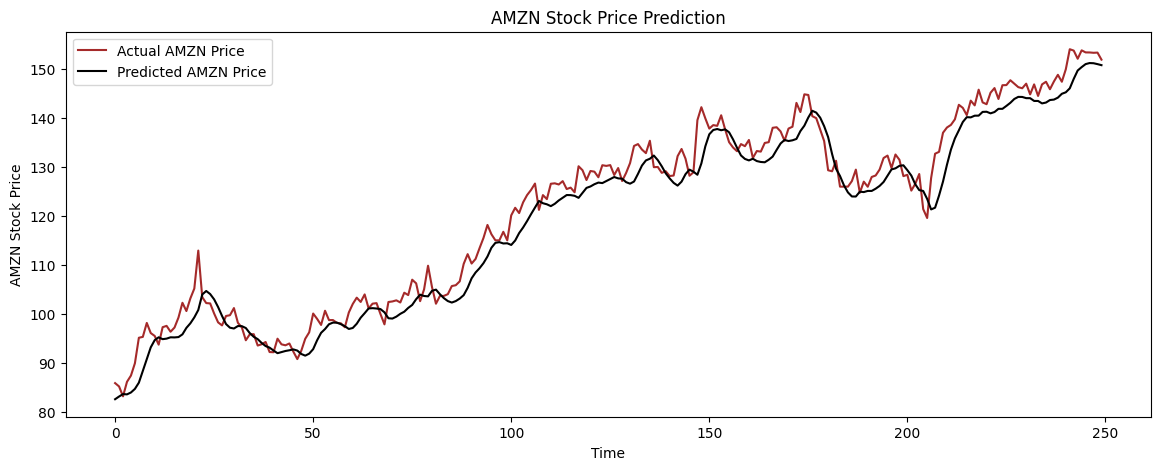

In [15]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='brown', label='Actual AMZN Price')
plt.plot(predictions, color='black', label='Predicted AMZN Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Stock Price')
plt.legend()
plt.show()